
# Image Classification with PyTorch and EfficientNetV2

**Author:** Shingo Nakazawa ([@shnakazawa](https://twitter.com/shnakazawa))

**Objective:** In this notebook, we will create a classification model using the [**EfficientNetV2 architecture**](https://arxiv.org/abs/2104.00298) with [**PyTorch**](https://pytorch.org/). ([A reference article (in Japanese)](https://zenn.dev/aidemy/articles/f851fb091dbb23))

EfficientNetV2 models have achieved great performance on a wide range of computer vision tasks, including image classification, object detection, and semantic segmentation. We will use **a pretrained model provided by [timm](https://huggingface.co/docs/timm/index), a popular library for computer vision tasks**. This will allow us to take advantage of the knowledge and expertise that has gone into developing the models and apply them to our use case.


Please see also 
- [Object Detection with PyTorch and DETR](https://www.kaggle.com/code/shnakazawa/object-detection-with-pytorch-and-detr/notebook)
- [Semantic Segmentation with PyTorch and U-Net](https://www.kaggle.com/code/shnakazawa/semantic-segmentation-with-pytorch-and-u-net)

# Import modules

In [2]:
import os
import numpy as np
import pandas as pd
import math
import time
import random
import gc
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f'PyTorch version {torch.__version__}')
print(f'Albumentations version {A.__version__}')

PyTorch version 1.13.0
Albumentations version 1.3.0


# Set Configs

Separatelly setting configs such as runnning objectives, file paths, hyperparameters, etc. is helpful in maintain a clear and organized workflow.

With clear configurations, it becomes easier to modify and fine-tune various aspects of the model. Moreover, it also helps in debugging the code, as each aspect can be tweaked and tested individually.

In [5]:
RUN_EDA = True
RUN_TRAINING = True
TRAIN_ALL = False # If true, train with all data and output a single model. If False, run cross-validation and output multiple models.
FOLD_NUM = 3 # For cross-validation
EPOCHS = 5 # Training cycle
RUN_INFERENCE = False

# Directory setting
DATA_DIR = '/kaggle/input/cassava-leaf-disease-classification/'
MODEL_DIR = '/kaggle/working/'
CSV_SAVE_DIR = '/kaggle/working/'
IMG_SAVE_DIR = '/kaggle/working/' 

# PyTorch variables 
# Das hier sagt dir aus, welche Konfigurationen dein Netzwerk hat
SEED = 42
NUM_CLASSES = 3 # df.nunique()['label']n (waren ursprünglich 5 habe ich jetzt schon auf 3 runtergenommen, weil so viele braucht man da ja nicht)
NUM_WORKERS = 2 #wie viele cpu kerne sind involviert, also das hat eigentlich keinen Einfluss auf das Ergebnis
BATCH_SIZE = 8

LR = 0.0001

# Define Helper Functions

Functions reused throughout the notebook should be defined at the top of the Notebook.

- **Organization and Readability**: Having helper functions defined at the top of a notebook makes it easier to read and understand the overall structure of the code. It also makes it easier to find and modify the functions as needed.

- **Debugging and Maintenance**: Defining helper functions separately allows for easier debugging and maintenance, as issues can be isolated to specific functions rather than having to comb through the entire notebook.

- **Code Efficiency**: By defining helper functions separately, it's possible to reuse the same code for different tasks and avoid code duplication, which can lead to a more efficient and streamlined workflow.

** Als nächstest werden nur ein Paar funktionen definert, die jetzt eher so mittel wichtig sind, aber schon auch praktisch sein können.


In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# Set seed
seed_everything(SEED)


def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")    

    
def load_img(path):
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb


def create_gallery(array, ncols=3):
    """Display multiple images in a gallery style.
    Source: https://www.amazon.co.jp/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34/
    
    Args:
        array (numpy.ndarray): array of images.
        ncols (int, optional): Num of columns. Defaults to 3.

    Returns:
        numpy.ndarray: One concatenated image.
    """    
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    return result


def show_validation_score(train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, save=False, save_dir=IMG_SAVE_DIR, save_name='classification_validation_score.png'):
    fig = plt.figure(figsize=(15,15))
    for i in range(FOLD_NUM):
        train_acc = train_acc_list[i]
        train_loss = train_loss_list[i]
        valid_acc = valid_acc_list[i]
        valid_loss = valid_loss_list[i]
        
        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM))*2, math.ceil(np.sqrt(FOLD_NUM))*2, (i*2)+1, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_acc, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_acc, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('accuracy')
        ax.legend()

        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM))*2, math.ceil(np.sqrt(FOLD_NUM))*2, (i*2)+2, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_loss, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_loss, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
    
    plt.tight_layout()
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir+save_name)
    else:
        plt.show()

# Load Data

In [6]:
df = pd.read_csv(DATA_DIR + 'train.csv') # ist jetzt eine vorgesetzte Variable, musst du dir noch auf deine Daten anpassen, deine Daten müssen da bei  Input mit rein
# kannst du dir anschauen wie die gerade organisert sind und dann einfach so ähnlich organisieren. Wenn du drüberfährst kannst du auch direkt den Pfad kopieren.
#besser schreibe auch:
os.path.join(DATA_DIR,'train.csv')

#csv bedeutet übirgens comma separated... das hat immer die Form
#jedem Label wird eine Zahl zugeordnet
# image_id, label
#10001 , 0 
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Exploratory Data Analysis (EDA)

EDA for images is typically simpler than for tabular data.

**Please set `RUN_EDA = True` in the `Set Config` section.**

## Check the Distribution of Labels

First, let's examine the images and their corresponding labels to see how many images are assigned to each label.

In [7]:
# hier siehst du halt wie oft Ball und so weiter vorkommt in deinem Fall dann.
# was auch immer Run_Eda genau ist, ist auf alle FÄlle oben als global variable mit definiert.
if RUN_EDA:
    print(df['label'].value_counts())
else:
    print('RUN_EDA is False')

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


## Inspect Representative Images

It is also essential to visually inspect a sample of images. 

If the images are noisy or weird, it may be necessary to apply some preprocessing steps before training a machine learning model.

1235188286.jpg, label: 2
1215607589.jpg, label: 3
478554372.jpg, label: 3
2763304605.jpg, label: 1
2826122413.jpg, label: 4
111117998.jpg, label: 3


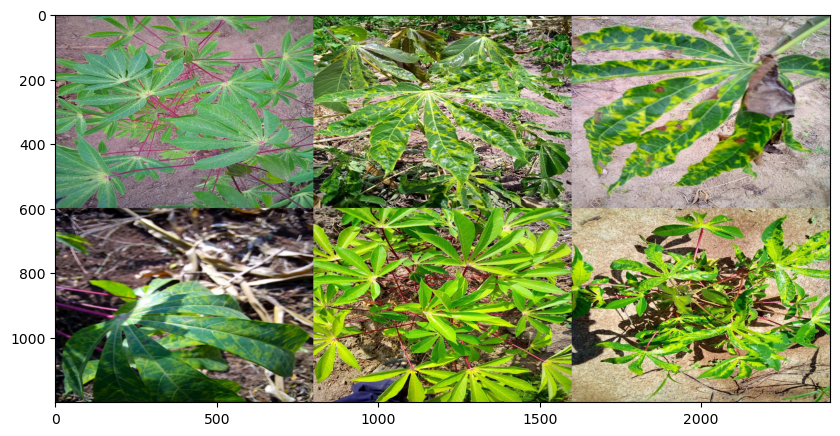

In [10]:
if RUN_EDA:
    img_names = Path(DATA_DIR+'train_images/').glob('*.jpg')
    img_list = []
    for i, img_name in enumerate(img_names):
        img_list.append(load_img(img_name.as_posix()))
        print(f'{img_name.name}, label: {df[df["image_id"]==img_name.name]["label"].to_numpy()[0]}')
        if i == 5: 
            break
    plt.figure(figsize=(10,10))
    plt.imshow(create_gallery(np.array(img_list), ncols=3))
else:
    print('RUN_EDA is False')

## Check Image Shape

It is also important to check the size and color of the images in the dataset. (The code below may take ~4 minutes.)

Creating histograms can also be helpful.

In [ ]:
if RUN_EDA:
    img_shape = set()
    img_ext = set()
    img_names = Path(DATA_DIR+'train_images/').glob('*')
    pbar = tqdm(img_names, total=len(df))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        img_shape.add(img.shape)
        img_ext.add(img_name.suffix)
    print(f'Image shapes are {img_shape}.')
    print(f'Image extensions are {img_ext}.')
else:
    print('RUN_EDA is False')

We are confident that all the images in the dataset are 600 x 800 RGB jpg.

## Plot histogram of pixel values

Creating a histogram of pixel values can help identify any outlier images (such as those with all zeros). (The code belwo may take ~6 minutes.)

In [ ]:
if RUN_EDA:
    img_names = Path(DATA_DIR+'train_images/').glob('*')
    plt.figure(figsize=(10,10))
    pbar = tqdm(img_names, total=len(df))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        hist = cv2.calcHist([img],[0],None,[256],[0,256])
        plt.plot(hist)
    plt.show()
else:
    print('RUN_EDA is False')

Some images show weird peaks. It may be necessary to either remove or modify these images to ensure reliable results.

While it is important to consider preprocessing steps to improve the accuracy of the model , for the purposes of simplicity, we will proceed to the next section without any preprocessing.

# Define Model Components

Before training a model using PyTorch, the following steps need to be completed:

1. Define Image Transformations and Augmentations
2. Define the Dataset
3. Define the DataLoader
4. Define the Model

## Define Image Transformations and Augmentations

Before creating the dataset, let's define the transformations and augmentations that will be applied to the images.

Here, a package [Albumentations](https://albumentations.ai/) is used.


In [ ]:
# Image Augmentation
def transform_train():
    transform = [
        A.Resize(512,512,p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.CoarseDropout(p=0.5),
        ToTensorV2(p=1.0)
    ]
    return A.Compose(transform)


# Validation (and test) images should only be resized.
def transform_valid():
    transform = [
        A.Resize(512,512,p=1),
        ToTensorV2(p=1.0)
    ]
    return A.Compose(transform)

## Define the Dataset

Using [`torch.datasets.ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) is an easier solution for preparing datasets. 

However, to better understand the process, we will define the datasets manually.

In [ ]:
# Dataset
class CassavaDataset(Dataset):
    def __init__(self, df, data_root, transforms=None, give_label=True):
        """Performed only once when the Dataset object is instantiated.
        give_label should be False for test data
        """ 
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.data_root = data_root
        self.transforms = transforms
        self.give_label = give_label
        
        if give_label == True:
            self.labels = self.df['label'].values

    def __len__(self):
        """Function to return the number of records in the dataset
        """ 
        return self.df.shape[0]
    
    def __getitem__(self, index):
        """Function to return samples corresponding to a given index from a dataset
        """ 
        # get labels
        if self.give_label:
            target = self.labels[index]

        # Load images
        img  = load_img(f'{self.data_root}/{self.df.loc[index]["image_id"]}').astype(np.float32)
        # img /= 255.0 # Normalization

        # Transform images
        if self.transforms:
            img = self.transforms(image=img)['image']

        if self.give_label == True:
            return img, target
        else:
            return img

## Define the DataLoader

In [ ]:
# DataLoader
def create_dataloader(df, trn_idx, val_idx):
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)

    # Dataset
    train_datasets = CassavaDataset(train_, DATA_DIR+'train_images/', transforms=transform_train())
    valid_datasets = CassavaDataset(valid_, DATA_DIR+'train_images/', transforms=transform_valid())

    # Data Loader
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')
    valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    return train_loader, valid_loader

## Define the Model

In this notebook, we will use a pre-trained EfficientNetV2 model prepared by `timm`.

In [ ]:
class EfficientNet_V2(nn.Module):
    def __init__(self, n_out):
        super(EfficientNet_V2, self).__init__()
        # Define model
        self.effnet = timm.create_model('efficientnetv2_s', pretrained=True, num_classes=n_out)

    def forward(self, x):
        return self.effnet(x)

# Run Training

To create an effective deep learning model, it's crucial to determine the optimal architecture and hyperparameters. 

One common approach for achieving this is to use **cross-validation**, a technique that involves dividing the available data into multiple subsets and using each subset in turn to train and validate the model. By **comparing the results obtained from different archigetcures and hyperparameters**, we can **identify the optimal combination** that maximizes the model's performance. To effectively track the model's performance, I recommend utilizing **MLOps tools like [MLFlow](https://mlflow.org/)**.

**Once the optimal architecture and hyperparameters have been identified** through cross-validation, we can proceed to **train the model on all available data** using the fixed architecture and hyperparameters.

It's worth noting that there is some debate over whether a single model should be re-trained on all available data or if an ensemble of models created during each round of cross-validation should be used instead. The choice between these options will depend on the specific use case and available resources.

- [StackExchange - How to choose a predictive model after k-fold cross-validation?](https://stats.stackexchange.com/questions/52274/how-to-choose-a-predictive-model-after-k-fold-cross-validation)
- [StackOverflow - k-fold cross validation model selection method](https://stackoverflow.com/questions/46860325/k-fold-cross-validation-model-selection-method)

## Cross-Validation

**Before running the following cell, please set `RUN_TRAINING = True` and `TRAIN_ALL = False` in the `Set Config` section.**

In [ ]:
if RUN_TRAINING and (TRAIN_ALL == False):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    print(f'Using {device} device')
    
    # Cross-validation
    folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)\
            .split(np.arange(df.shape[0]), df['label'].to_numpy())

    # For Visualization
    train_acc_list = []
    valid_acc_list = []
    train_loss_list = []
    valid_loss_list = []


    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'==========Cross Validation Fold {fold+1}==========')
        # Load Data
        train_loader, valid_loader = create_dataloader(df, trn_idx, val_idx)

        # Load model, loss function, and optimizing algorithm
        model = EfficientNet_V2(NUM_CLASSES).to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=LR)
                
        # For Visualization
        train_accs = []
        valid_accs = []
        train_losses = []
        valid_losses = []

        # Start training
        best_acc = 0
        for epoch in range(EPOCHS):
            time_start = time.time()
            print(f'==========Epoch {epoch+1} Start Training==========')
            model.train()
            
            epoch_loss = 0
            epoch_accuracy = 0
        
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, (img, label) in pbar:
                img = img.to(device).float()
                label = label.to(device).long()

                output = model(img)
                loss = loss_fn(output, label)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc = (output.argmax(dim=1) == label).float().mean()
                epoch_accuracy += acc / len(train_loader)
                epoch_loss += loss / len(train_loader)

            print(f'==========Epoch {epoch+1} Start Validation==========')
            with torch.no_grad():
                epoch_val_accuracy = 0
                epoch_val_loss = 0
                val_labels = []
                val_preds = []

                pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
                for step, (img, label) in pbar:
                    img = img.to(device).float()
                    label = label.to(device).long()

                    val_output = model(img)
                    val_loss = loss_fn(val_output, label)

                    acc = (val_output.argmax(dim=1) == label).float().mean()
                    epoch_val_accuracy += acc / len(valid_loader)
                    epoch_val_loss += val_loss / len(valid_loader)

                    val_labels += [label.detach().cpu().numpy()]
                    val_preds += [torch.argmax(val_output, 1).detach().cpu().numpy()]
                
                val_labels = np.concatenate(val_labels)
                val_preds = np.concatenate(val_preds)
            
            # print result from this epoch
            exec_t = int((time.time() - time_start)/60)
            print(
                f'Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} / Exec time {exec_t} min\n'
            )

            # For visualization
            train_accs.append(epoch_accuracy.cpu().numpy())
            valid_accs.append(epoch_val_accuracy.cpu().numpy())
            train_losses.append(epoch_loss.detach().cpu().numpy())
            valid_losses.append(epoch_val_loss.detach().cpu().numpy())
        
        train_acc_list.append(train_accs)
        valid_acc_list.append(valid_accs)
        train_loss_list.append(train_losses)
        valid_loss_list.append(valid_losses)
        del model, optimizer, train_loader, valid_loader, train_accs, valid_accs, train_losses, valid_losses
        gc.collect()
        torch.cuda.empty_cache()

    show_validation_score(train_acc_list, train_loss_list, valid_acc_list, valid_loss_list)

else:
    print('Cross validation is not performed')


Loss is still decreasing. In practical terms, it is advisable to continue learning until the loss reaches a plateau. 

Here, we will go on the next step with this “incomplete” setting.

## Training on All Data

After identifying **the optimal number of epochs and hyperparameters** through cross-validation, the final step is to **use this information to train the model on all available data**.

To simplify the process and avoid errors, **combining the code for cross-validation and training on all data into a single script can be helpful**.  This approach allows for a more efficient workflow and simplifies the process of transitioning from cross-validation to training with all  data.

**Before running the following cell, please set `RUN_TRAINING = True` and `TRAIN_ALL = True` in the `Set Config` section.**

In [ ]:
if RUN_TRAINING and TRAIN_ALL:
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    print(f'Using {device} device')

    # Load Data
    train_datasets = CassavaDataset(df, DATA_DIR+'train_images/', transforms=transform_train())
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')
    

    # Load model, loss function, and optimizing algorithm
    model = EfficientNet_V2(NUM_CLASSES).to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
            
    # Start training
    for epoch in range(EPOCHS):
        time_start = time.time()
        print(f'==========Epoch {epoch+1} Start Training==========')
        model.train()
        
        epoch_loss = 0
        epoch_accuracy = 0
    
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for step, (img, label) in pbar:
            img = img.to(device).float()
            label = label.to(device).long()

            output = model(img)
            loss = loss_fn(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)
                  
        # print results from this epoch
        exec_t = int((time.time() - time_start)/60)
        print(
            f'Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} / Exec time {exec_t} min\n'
        )

    print(f'Save model trained with all data')
    os.makedirs(MODEL_DIR, exist_ok=True)
    torch.save(model.state_dict(), MODEL_DIR+'classification.pth')       
                 
    del model, optimizer, train_loader
    gc.collect()
    torch.cuda.empty_cache()

else:
    print('Training with all data is not performed')

By creating a final model using the parameters obtained from cross-validation, we could be confident that our deep learning model is optimized for the specific task at hand. 

However, it's important to keep in mind that deep learning models are not a one-size-fits-all solution and may **need to be adjusted or retrained as new data becomes available or the task requirements change**.
This is particularly important to consider when tackling your own projects.

# Run Inference of Test Data

In this task, the same Dataset, Image transformation, and model as we used for validation. So no need to define new functions.

**Before running the following cells, please set `RUN_INFERENCE = True` in the `Set Config` section.**

In [ ]:
if RUN_INFERENCE:
    submission_df = pd.DataFrame()
    submission_df['image_id'] = list(os.listdir(DATA_DIR+'test_images/'))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
    print(f'Using {device} device')

    # Load Data
    test_datasets = CassavaDataset(submission_df, DATA_DIR+'test_images/', transforms=transform_valid(), give_label=False)

    # Data Loader
    test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    # Load model, loss function, and optimizing algorithm
    model = EfficientNet_V2(NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(MODEL_DIR+'classification.pth'))

    # Start Inference
    print(f'==========Start Inference==========')
    with torch.no_grad():
        test_preds = []
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, img in pbar:
            img = img.to(device).float()
            test_output = model(img)
            test_preds += [torch.argmax(test_output, 1).detach().cpu().numpy()]
        test_preds = np.concatenate(test_preds)
    submission_df['label'] = test_preds
    submission_df.head()

else:
    print('RUN_INFERENCE is False')

## Save inference result

In [ ]:
if RUN_INFERENCE:
    submission_df.to_csv('submission.csv', index=False)
    
else:
    print('RUN_INFERENCE is False')

# To Improve the Model

Our classification model is now on the starting point. There are many techniques we can use to improve its accuracy.

Some potential approaches to consider include:

- **Image preprocessing**
    - Dimensionality reduction, feature extraction, removal of unnecessary background
    - Correction or removal of mislabeled images
    - Review of augmentation
        - Increase the patterns generated
        - **Check if any strange images are generated as a result of augmentation**
- **Handling imbalanced data**
    - Up-sampling/down-sampling 
    - Changing the loss function
        - [This loss function](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733) was commonly used in this competition
- Increase the image size beyon the current 224 x 224 pixels
- **Model optimization**
    - Switching to larger architectures such as 'efficientnetv2_l'
    - Applying different architectures
    - Increasing input size
    - Tuning hyperparameters
- **Feedback from prediction results**
    - **Creating a confusion matrix** from validation results
    - Identifying mislabeled data and labels that are prone to errors
- **Ensemble of multiple models**
- Checking for bugs
- etc...

By evaluating the performance of each approach carefully, we can identify the best approach to improve the accuracy of our model for our specific task and dataset.

I hope this notebook has been helpful in building a classification model, and I wish you the best of luck in your modeling life!

# Acknowledgement

I thank to [Matchan from YouTube Channel - Engawa AI Research Institute](https://www.youtube.com/channel/UCRwO-ewBHhNiC4qBEppi_JQ) and Mr. Masaaki Aiba for critical reviews and valuable discussion.

# References

- [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/abs/2104.00298) 
- [PyTorch](https://pytorch.org/)
	- [PyTorch - SAVING AND LOADING MODELS](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
- [Albumentations](https://albumentations.ai/)
- [huggingface/timm](https://huggingface.co/docs/timm/index)
- [sklearn.model_selection.StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)
- [Kaggle Cassava Leaf Disease Classification competition](https://www.kaggle.com/c/cassava-leaf-disease-classification)
- [Pytorch Efficientnet Baseline [Train] AMP+Aug](https://www.kaggle.com/code/khyeh0719/pytorch-efficientnet-baseline-train-amp-aug)
- [Pytorch Efficientnet Baseline [Inference] TTA](https://www.kaggle.com/code/khyeh0719/pytorch-efficientnet-baseline-inference-tta)
- [StackExchange - How to choose a predictive model after k-fold cross-validation?](https://stats.stackexchange.com/questions/52274/how-to-choose-a-predictive-model-after-k-fold-cross-validation)
- [StackOverflow - k-fold cross validation model selection method](https://stackoverflow.com/questions/46860325/k-fold-cross-validation-model-selection-method)